In [1]:
import librosa
import librosa.display
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# # code to clear up the output folders

# import shutil
# import os

# working_dir = "/kaggle/working"

# for item in os.listdir(working_dir):
#     item_path = os.path.join(working_dir, item)
#     try:
#         if os.path.isdir(item_path):
#             shutil.rmtree(item_path)
#         else:
#             os.remove(item_path)
#     except Exception as e:
#         print(f"Couldn't delete {item_path}: {e}")


In [2]:
# Paths
dataset_dir = "/kaggle/input/toronto-emotional-speech-set-tess"
output_dir = "/kaggle/working/spectrograms"
os.makedirs(output_dir, exist_ok=True)

# Constants
TARGET_DURATION = 6  # seconds
SAMPLE_RATE = 22050  # default librosa sample rate
TARGET_LEN = SAMPLE_RATE * TARGET_DURATION

def preprocess_and_save(audio_path, output_path):
    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

    # Normalize
    y = (y - np.mean(y)) / np.std(y)

    # Trim or pad
    if len(y) > TARGET_LEN:
        y = y[:TARGET_LEN]
    else:
        y = np.pad(y, (0, TARGET_LEN - len(y)))

    # Mel spectrogram using paper settings
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=1024,
        hop_length=int(sr * 0.010),
        win_length=int(sr * 0.025),
        window='hamming',
        n_mels=128
    )
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Save as image
    plt.figure(figsize=(3, 3))
    librosa.display.specshow(S_DB, sr=sr, x_axis=None, y_axis=None)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Go through all .wav files
for root, dirs, files in os.walk(dataset_dir):
    for file in tqdm(files):
        if file.endswith(".wav"):
            emotion = file.split("_")[-1].replace(".wav", "")  # Example: happy, angry, etc.
            emotion_dir = os.path.join(output_dir, emotion)
            os.makedirs(emotion_dir, exist_ok=True)

            audio_path = os.path.join(root, file)
            output_path = os.path.join(emotion_dir, file.replace(".wav", ".png"))
            preprocess_and_save(audio_path, output_path)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 200/200 [00:29<00:00,  6.75it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 200/200 [00:28<00:00,  7.04it/s]


In [3]:
from PIL import Image
img = Image.open("/kaggle/working/spectrograms/angry/OAF_back_angry.png")
print(img.mode)

RGBA


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transform for ResNet
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # convert RGBA to RGB
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.ImageFolder("/kaggle/working/spectrograms", transform=transform)

from torch.utils.data import random_split

# Calculate sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [5]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final FC layer first
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Unfreeze last 2 blocks + new fc layer
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


In [6]:
# Storing Training Stats
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
precisions = []
recalls = []
f1_scores = []
scores = []

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

def Train_model(model, e, fold_no, train_loader, val_loader, optimizer, loss_func):
    counter = 0
    patience = 7
    best_score = 0

    for epoch in range(e):
        model.train()
        total_loss = 0
        train_total = 0
        train_correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            total_loss += loss.item()

        train_accuracy = train_correct / train_total * 100
        train_losses.append(total_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_total_loss = 0
        pred_classes = []
        actual_classes = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_func(outputs, labels)
                val_total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                pred_classes.extend(predicted.cpu().numpy())
                actual_classes.extend(labels.cpu().numpy())

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total * 100
        precision = precision_score(actual_classes, pred_classes, average='weighted')
        recall = recall_score(actual_classes, pred_classes, average='weighted')
        f1 = f1_score(actual_classes, pred_classes, average='weighted')

        val_losses.append(val_total_loss)
        val_accuracies.append(val_accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f"Epoch: {epoch+1}, Train Loss: {total_loss:.2f}, "
              f"Train Acc: {train_accuracy:.2f}%, Val Loss: {val_total_loss:.2f}, "
              f"Val Acc: {val_accuracy:.2f}%")
        print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

        current_score = (f1 + val_accuracy / 100) / 2

        if current_score > best_score:
            best_score = current_score
            scores.append(best_score)
            counter = 0
            torch.save(model.state_dict(), f"best_model_{fold_no}.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break


In [8]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [9]:
num_epochs = 50
fold_no = 1  

Train_model(model, num_epochs, fold_no, train_loader, val_loader, optimizer, loss_func)

Epoch: 1, Train Loss: 21.15, Train Acc: 91.68%, Val Loss: 0.39, Val Acc: 99.29%
Precision: 0.99, Recall: 0.99, F1: 0.99
Epoch: 2, Train Loss: 1.79, Train Acc: 99.74%, Val Loss: 0.18, Val Acc: 100.00%
Precision: 1.00, Recall: 1.00, F1: 1.00
Epoch: 3, Train Loss: 1.21, Train Acc: 99.64%, Val Loss: 0.11, Val Acc: 99.76%
Precision: 1.00, Recall: 1.00, F1: 1.00
Epoch: 4, Train Loss: 0.37, Train Acc: 100.00%, Val Loss: 0.07, Val Acc: 100.00%
Precision: 1.00, Recall: 1.00, F1: 1.00
Epoch: 5, Train Loss: 0.24, Train Acc: 100.00%, Val Loss: 0.06, Val Acc: 100.00%
Precision: 1.00, Recall: 1.00, F1: 1.00
Epoch: 6, Train Loss: 0.55, Train Acc: 99.95%, Val Loss: 0.04, Val Acc: 100.00%
Precision: 1.00, Recall: 1.00, F1: 1.00
Epoch: 7, Train Loss: 1.08, Train Acc: 99.64%, Val Loss: 0.13, Val Acc: 99.52%
Precision: 1.00, Recall: 1.00, F1: 1.00
Epoch: 8, Train Loss: 0.15, Train Acc: 100.00%, Val Loss: 0.05, Val Acc: 100.00%
Precision: 1.00, Recall: 1.00, F1: 1.00
Epoch: 9, Train Loss: 0.18, Train Acc: 

In [10]:
# Load best model
model.load_state_dict(torch.load(f"best_model_{fold_no}.pth"))
model.to(device)
model.eval()

# Evaluate on validation set
val_correct = 0
val_total = 0
pred_classes = []
actual_classes = []

with torch.no_grad():
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        pred_classes.extend(predicted.cpu().numpy())
        actual_classes.extend(labels.cpu().numpy())

        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

accuracy = val_correct / val_total * 100
precision = precision_score(actual_classes, pred_classes, average='weighted')
recall = recall_score(actual_classes, pred_classes, average='weighted')
f1 = f1_score(actual_classes, pred_classes, average='weighted')

print(f"Final Model Stats:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Final Model Stats:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


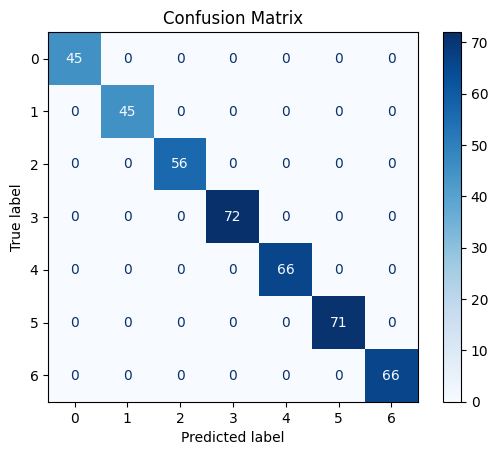

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(actual_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()